In [1]:
import sys
# https://docs.python.org/3/library/hashlib.html#hash-algorithms
import hashlib
# https://pymultihash.readthedocs.io/en/latest/#
import multihash
# https://py-multicodec.readthedocs.io/en/stable/
from multicodec import add_prefix, remove_prefix, get_codec
# https://github.com/multiformats/py-multibase
import multibase
# https://github.com/parrt/lolviz
from lolviz import *
# https://github.com/parrt/lolviz#preferencess
prefs.max_str_len = 64
# https://github.com/parrt/lolviz/blob/master/examples.ipynb
from IPython.display import display
# https://bitstring.readthedocs.io/en/latest/index.html
from bitstring import Bits, BitArray, BitStream, ConstBitStream
# https://github.com/multiformats/unsigned-varint
import varint
# https://github.com/tqdm/tqdm
from tqdm import tqdm
# https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html#object-creation
import numpy as np
import pandas as pd

In [3]:
# исходные данные изображения до сжатия
imageData = ConstBitStream(filename='data/test-image.tiff')
len(imageData)

1573984

In [4]:
def findStartBits(data):
    """
    Найти позиции базовых значений (1 и 0)
    Эта функция не изменяет положения курсора
    """
    result = {
        "0b0": data.find('0b0', start=0, bytealigned=False),
        "0b1": data.find('0b1', start=0, bytealigned=False),
    }
    data.bitpos = 0
    return result

testFindStartBits = findStartBits(imageData)
print(imageData[0:16].bin, '|', testFindStartBits, 'imageData.bitpos:', imageData.bitpos)

0100110101001101 | {'0b0': (0,), '0b1': (1,)} imageData.bitpos: 0


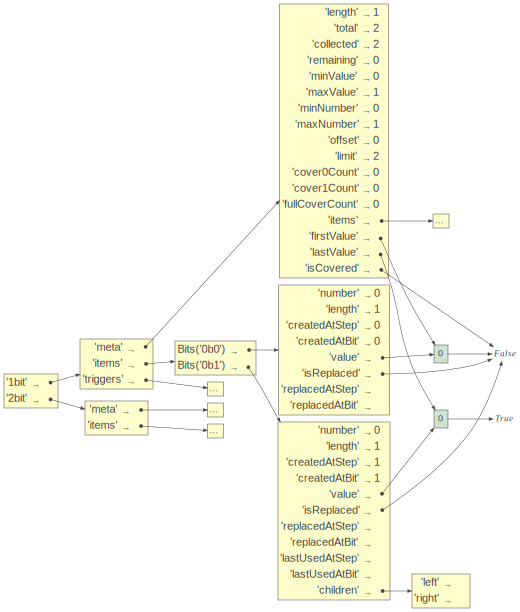

In [5]:
# создаем словарь для хранения битовых отрезков на которые будет разбит файл
VALUES = {
    "1bit": {
        "meta": {
            # длина любого значения из этого множества в битах
            "length": 1,
            # статистика по элементам множества
            "items": {},
            # всего элементов в множестве (элементы с ведущими нулями не учитываются)
            "total": 2,
            # открыто/найдено значений в процессе кодирования и сжатия
            "collected": 2,
            # количество еще не найдено ()
            "remaining": 0,
            # первое найденное значение
            "firstValue": Bits('0b0'),
            # последнее найденное значение
            "lastValue": Bits('0b1'),
            # минимальное положительное целое представимое этим количеством бит
            "minValue": 0,
            # максимальное положительное целое представимое этим количеством бит
            "maxValue": 1,
            # стартовый номер нового элемента в множестве 
            # (нумерация с 0, увеличивается с каждым новым значением)
            "minNumber": 0,
            # максимальный номер элемента внутри множества (среди значений такой же длины)
            "maxNumber": 1,
            # смещение: число с которого начинаются целочисленные значения из этого множеста
            # начинается за последним значением множества на 1 бит меньше 
            "offset": 0,
            # верхняя (строгая) граница целых значений множества с учетом смещения
            # limit = offset + total
            "limit": 2,
            # имеет полное покрытие каждого элемента другим элементом 
            # из множеством более высокого порядка (хотя бы 1 раз)
            "isCovered": False,
            # количество элементов этого множества покрытых только со стороны 0
            "cover0Count": 0,
            # количество элементов этого множества покрытых только со стороны 1
            "cover1Count": 0,
            # элементы для которых существуют оба покрытия
            "fullCoverCount": 0,
        },
        "items": {
            Bits('0b0'): {
                "number": 0,
                "value": Bits('0b0'),
                "length": 1,
                "createdAtStep": 0,
                "createdAtBit": 0,
                "isReplaced": False,
                "replacedAtStep": None,
                "replacedAtBit": None,
            },
            Bits('0b1'): {
                "number": 0,
                "value": Bits('0b1'),
                "length": 1,
                "createdAtStep": 1,
                "createdAtBit": 1,
                # элемент может быть заменен если у него заполнены оба потомка (0 и 1)
                # значениями длины n+1 бит (то есть существует дополнение с 0 и с 1)
                # либо если для 0 и 1 дополнений существуют все возможные комбинации бит
                # элемент можно заменить если любой поиск элемента начинается с числа бит
                # которое строго больше длины этого элемента
                "isReplaced": False,
                # шаг энкодера после которого минимальное значение при поиске стало больше длины
                # этого элемента
                "replacedAtStep": None,
                # бит данных на котором стала доказана возможность замены
                "replacedAtBit": None,
                # последний шаг энкодера, содержащий прямую ссылку на этот элемент
                "lastUsedAtStep": None,
                "lastUsedAtBit": None,
                # потомки узла - левый и правый: создаются как ссылки на значения словаря
                # в ссылке указывается длина значения и его порядковый номер
                # среди значений такой же длины в нашем словаре
                # левое значение всегда дополняется 0 а правое 1
                "children": {
                    "left": None,
                    "right": None,
                }
            }
        },
        "triggers": {}
    }
}
VALUES["2bit"] = {
    "meta": {},
    "items": {}
}
display(objviz(VALUES))

0100110101001101 0000000000101010 0000000000000011 0000000000001000


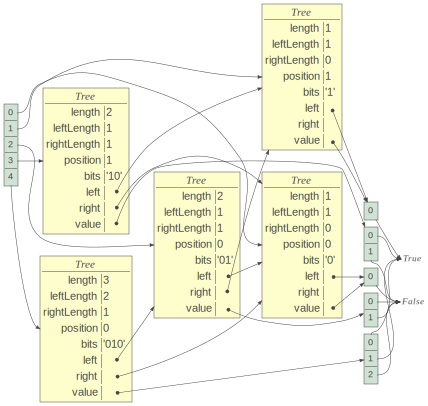

In [56]:
# Специальные классы узла и дерева для совместимости с отображением в graphviz/lolviz
# https://github.com/parrt/lolviz/blob/master/examples.ipynb

class Node:
    def __init__(self, value, next=None):
        self.value = value
        self.next  = next

class Tree:
    def __init__(self, position, left=None, right=None):
        self.left        = left
        self.right       = right
        if (isinstance(self.left, Bits) and isinstance(self.right, Bits)):
            self.value = self.left.append(self.right)
        elif (isinstance(self.left, Bits) and (self.right == None)):
            self.value = self.left
        elif (isinstance(self.right, Bits) and (self.left == None)):
            self.value = self.right
        elif (isinstance(self.left, Tree) and (self.right == None)):
            self.value = self.left.value
        elif (isinstance(self.right, Tree) and (self.left == None)):
            self.value = self.right.value
        elif (isinstance(self.left, Tree) and isinstance(self.right, Tree)):
            self.value = self.left.value + self.right.value
        else:
            raise ValueError("incorrect left and right values")
        # default length for empty values is 0
        self.length      = 0
        self.leftLength  = 0
        self.rightLength = 0
        # first bit position
        self.position    = position
        # creating binary representation for value
        if (self.value != None):
            self.bits   = self.value.bin
        # length of the left value
        if (self.left != None):
            if (isinstance(self.left, Bits)):
                self.leftLength  = len(self.left)
            elif (isinstance(self.left, Tree)):
                self.leftLength  = len(self.left.value)
        # right value length
        if (self.right != None):
            if (isinstance(self.right, Bits)):
                self.rightLength  = len(self.right)
            elif (isinstance(self.right, Tree)):
                self.rightLength  = len(self.right.value)
        # TODO: проверять что сумма длинн сходится с длинной значения
        self.length = self.leftLength + self.rightLength

class DataItem:
    """
    Элемент списка: состоит из ссылки на значение словаря (Tree) и следующего элемента (Tree)
    Следующий элемент всегда добавляется из словаря, словарь составляется из сжимаемых данных
    рекурсивно
    
    Уровень значения означает глубину покрытия данных заменами: 
    - 0: уровень исходных данных - для размещения в нем элементов можно использовать только ранее
         созданные значения словаря
    - 1: уровень, создаваемый соединением двух соседних элементов уровня 0 в одно значение
    - 2: уровень создаваемый двумя соседними значениями уровня 1
    - 3: создается соединением соседних значений уровня 1 и 2 или соединением 2 с уровнем 1
    - 4: создается как 1+3, 2+2 или 3+1

    Стыковка двух соседних элементов происходит автоматически после каждого использования 
    словарного значения на уровне 0
    Новое значение уровня 0 после попадания в список должно соединиться с предыдущим 
    значением списка того же уровня 0
    Таким образом, каждое использование значения из словаря порождает в нем новое значение-пару
    из двух соседних элементов, причем значение этой пары будет уникальным для словаря
    """
    def __init__(self, position, value, next=None, options={}):
        self.value    = value
        # длина фрагмента данных, который заменяется ссылкой на значение словаря (Tree)
        self.length   = len(self.value)
        # абсолютная позиция начального бита данных в исходном потоке
        self.position = position
        # ссылка на следующий элемент списка - значение словаря, 
        # которое заменяет следующий фрагмент сжимаемых данных
        self.next     = next
        # self.prev = self.getPrev()

# e_empty = Tree(0, None, None)
e_0b0   = Tree(0, Bits('0b0'), None)
e_0b1   = Tree(1, Bits('0b1'), None)
e_0b01  = Tree(0, e_0b0, e_0b1)
e_0b10  = Tree(1, e_0b1, e_0b0)
e_0b010 = Tree(0, e_0b01, e_0b0)

# print(imageData[0:64].bin)
print(imageData[0:16].bin, imageData[16:32].bin, imageData[32:48].bin, imageData[48:64].bin)
display(objviz([e_0b0, e_0b1, e_0b01, e_0b10, e_0b010]))

0 :
1 :
2 :
3 :
4 :
5 :
6 :
7 :
8 :
9 :
10 :
11 :
12 :
13 :
14 :
15 :


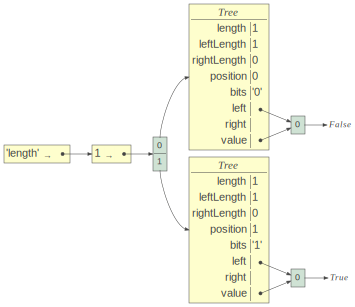

In [54]:
# тест первых 32 шагов упаковщика данных:
# - создает в словаре изначальные константы 0 и 1
# - рекурсивно создает в словаре новые значения как комбинацию базовых элементов
# - на каждом шаге сжатия один фрагмент исходных данных заменяется ссылкой 
#   на одно значение из словаря
# - на каждом шаге сжатия к предыдущему использованному значению словаря
#   на уровне 0 добавляется текущее значение словаря. Они соединяются в пару
#   и их объединение добавляются в словарь как новое значение
# - добавление в словарь нового значение из 2 старых происходит после регистрации замены данных
#   ссылкой на словарь: для этого берутся два последних использованных значения словаря
#   (они стоят рядом в сжимаемой последовательности) и регистрируются как Tree
# - список блоков, на которые разбивается сжимаемая последовательность бит может состоять только
#   из ссылок на значения словаря
# - изначально не объединяем значения выше 0 уровня чтобы не перегружать словарь
# - правило выбора значения: самая короткая не до конца открытая последовательность можно
#   использовать для создания новых элементов в паре с любыми значениями
# - по умолчанию на каждом шаге происходит только 1 замена данных словарными значением
#   и только 1 создание нового значения в словаре (на этом же шаге)

position  = 0
maxLength = 1
maxCoveredLength = 1
values = {
    "length": {
        1: [e_0b0, e_0b1],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
    }
}

for step in range(0, 32):
    # 1) определяем сколько бит мы изначально пытаемся найти в данных
    # 2) читаем максимальное количество бит, которое у нас есть в словаре
    # 3) убираем из прочитанного по 1 биту до тех пор пока не дойдем 
    # до существующих в словаре значений
    # 4) дополняем список блоков данных, добавляя в него сверху ссылку на значение словаря
    # 5) передвигаем указатель на длину значения в словаре
    # 6) получаем прошлое и текущее значение списка блоков и создаем из этой пары новое
    #    уникальное значение словаря
    # 7) обновляем метаданные словаря (количество значений каждой длины, 
    #    количество использований значения, количество связок, количество элементов в списке,
    #    список полностью открытых значений для каждой длины)
    # 8) история и логи шага: какой элемент словаря был создан из каких двух частей,
    #    сколько бит данных было заменено последней ссылкой на словарь, какая последовательность 
    #    (длина) была полностью занесена в словарь на этом шаге, для какой 
    #    появилось первое значение пара между какими длинами была добавлена
    print(step, ':')

display(objviz(values))

## Проверка замен по словарю: восстановление фрагмента данных

Восстановить обратной заменой по словарю все 32 блока, убедится что бинарные данные сходятся с исходными

## Просмотр истории сжатия

## Просмотр истории добавления значений в словарь и истории использования элементов словаря

0100110101001101 imageData.bitpos: 0


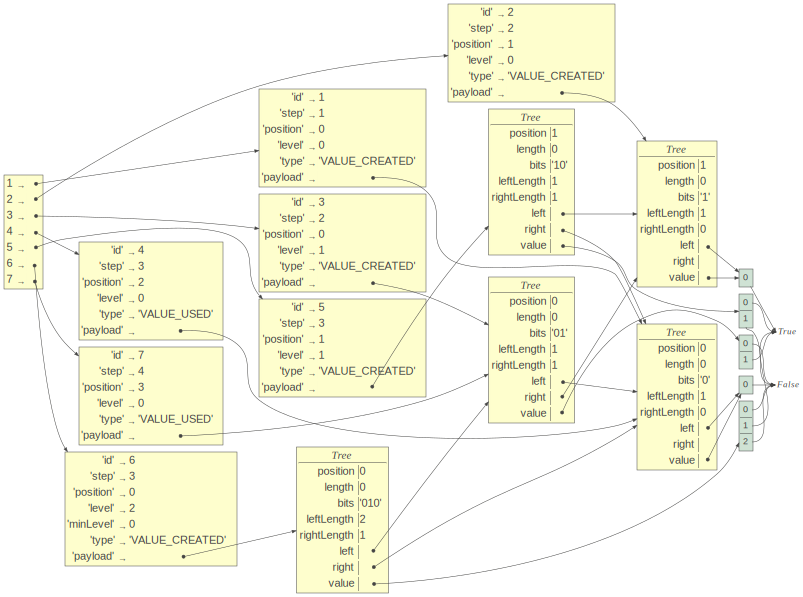

In [46]:
EVENTS = {
    1: {
        "id": 1,
        "step": 1,
        "position": 0,
        "level": 0,
        "type": "VALUE_CREATED",
        "payload": e_0b0
    },
    2: {
        "id": 2,
        "step": 2,
        "position": 1,
        "level": 0,
        "type": "VALUE_CREATED",
        "payload": e_0b1
    },
    3: {
        "id": 3,
        "step": 2,
        "position": 0,
        "level": 1,
        "type": "VALUE_CREATED",
        "payload": e_0b01
    },
    4: {
        "id": 4,
        "step": 3,
        "position": 2,
        "level": 0,
        "type": "VALUE_USED",
        "payload": e_0b0
    },
    5: {
        "id": 5,
        "step": 3,
        "position": 1,
        "level": 1,
        "type": "VALUE_CREATED",
        "payload": e_0b10
    },
    6: {
        "id": 6,
        "step": 3,
        "position": 0,
        "level": 2,
        "minLevel": 0,
        "type": "VALUE_CREATED",
        "payload": e_0b010
    },
    7: {
        "id": 7,
        "step": 4,
        "position": 3,
        "level": 0,
        "type": "VALUE_USED",
        "payload": e_0b01
    },
}

print(imageData[0:16].bin, 'imageData.bitpos:', imageData.bitpos)
display(objviz(EVENTS))

In [47]:
# извлекать значения по уровнямы

In [ ]:
# определить, есть ли в словаре потенциальные предки для порождения нового значения 
# новые значения можно создавать только из элементов с пустыми ссылками в ячейке для 
# прикрепления потомка
def hasParentForNewValue(newValue):
    return False

In [ ]:
# найти в словаре родительский элемент от которого будут наследоваться новое зачение
def findParentForNewValue(newValue):
    # на первом шаге при чтении первого бита всегда используем нулевой элемент как корень
    if (dictMeta["totalValues"] == 1) {
        return valuesDict[0]
    }
   return {} 

In [ ]:
# прочитать и закодировать еще один фрагмент сжимаемых данных: этот метод определяет
# сколько бит данных нужно прочесть из сжимаемого потока, каким значением дополнить словарь и как
def encodeElement():
    return {}

In [ ]:
# создать в словаре новое значение путем добавления 1 или 0 к существующему старому
def createElementFromValue(parentElement, appendBit, step):
    return {}